# Geometry of Sliding Window Embeddings
In this module, you will interactively explore how various parameters of sliding window embeddings of 1 dimensional periodic time series data affect the geometry of their embeddings.  In each code box, press *ctrl-enter* (or *cmd-enter* on a Mac) to execute the code. Progress through the lab sequentially. As you examine the plots in each experiment, answer the questions that follow.

This first box imports all of the necessary Python packages to run the code in this module. There will be a similar box at the beginning of every module in this series.

In [1]:
#Do all of the imports and setup inline plotting
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA

import scipy.interpolate as interp

import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

from TDA import *

## Pure Sinusoid Sliding Window
In this first experiment, you will alter the extent of the sliding window of a pure sinusoid and examine how the geometry of a 2-D embedding changes.  

First, setup and plot a pure sinusoid in NumPy:

<IPython.core.display.Javascript object>


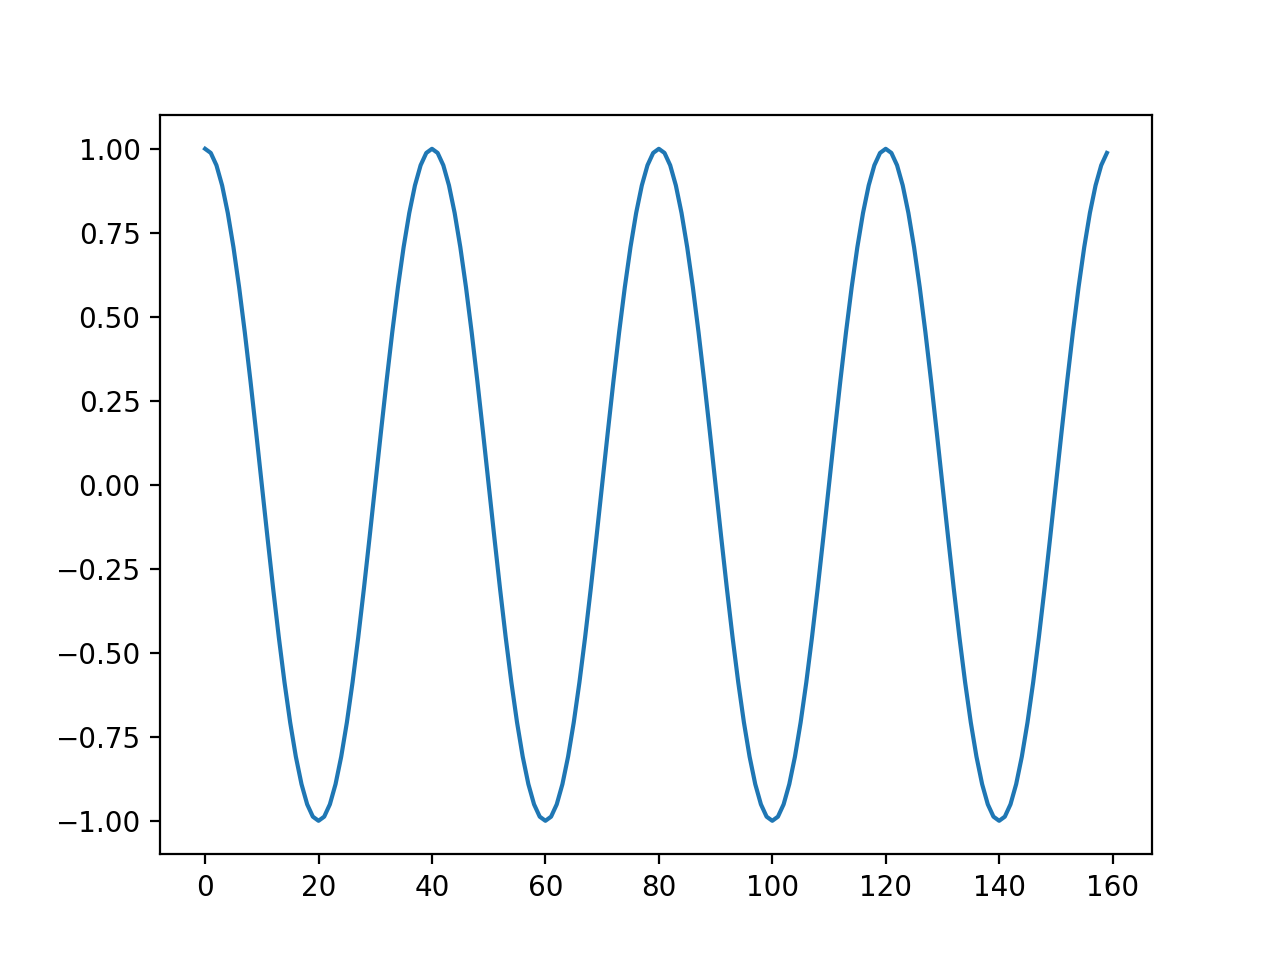

In [2]:
# Step 1: Setup the signal
T = 40 # The period in number of samples
NPeriods = 4 # How many periods to go through
N = T*NPeriods #The total number of samples
t = np.linspace(0, 2*np.pi*NPeriods, N+1)[:N] # Sampling indices in time
x = np.cos(t) # The final signal
plt.plot(x);

## Sliding Window Code
The code below performs a sliding window embedding on a 1D signal.  The parameters are as follows:

| | |
|:-:|---|
|$x$   | The 1-D signal (numpy array)   |
|dim|The dimension of the embedding|
|$\tau$   | The skip between samples in a given window  |
|$dT$   | The distance to slide from one window to the next  |

That is, along the signal given by the array $x$, the first three windows will will be $$\begin{bmatrix} x(\tau)\\ x(2\tau) \\ \ldots \\ x((\mbox{dim}-1)\cdot\tau)\end{bmatrix},  \begin{bmatrix} x(dT + \tau)\\ x(dT +2\tau) \\ \ldots \\ x(dT +(\mbox{dim}-1)\cdot\tau)\end{bmatrix},  \begin{bmatrix} x(2dT + \tau)\\ x(2dT +2\tau) \\ \ldots \\ x(2dT +(\mbox{dim}-1)\cdot\tau)\end{bmatrix}$$

Spline interpolation is used to fill in information between signal samples, which is necessary for certain combinations of parameters, such as a non-integer $\tau$ or $dT$.

The function *getSlidingWindow* below creates an array $X$ containing the windows as its columns.

In [3]:
def getSlidingWindow(x, dim, Tau, dT):
    N = len(x)
    NWindows = int(np.floor((N-dim*Tau)/dT)) # The number of windows
    if NWindows <= 0:
        print("Error: Tau too large for signal extent")
        return np.zeros((3, dim))
    X = np.zeros((NWindows, dim)) # Create a 2D array which will store all windows
    idx = np.arange(N)
    for i in range(NWindows):
        # Figure out the indices of the samples in this window
        idxx = dT*i + Tau*np.arange(dim) 
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))+2
        if end >= len(x):
            X = X[0:i, :]
            break
        # Do spline interpolation to fill in this window, and place
        # it in the resulting array
        X[i, :] = interp.spline(idx[start:end+1], x[start:end+1], idxx)
    return X

## Sliding Window Result

We will now perform a sliding window embedding with various choices of parameters.  [Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) will be performed to project the result down to 2D for visualization.  

The first two eigenvalues computed by PCA will be printed.  The closer these eigenvalues are to each other, the rounder and more close to a circle the 2D projection of the embedding is. A red vertical line will be drawn to show the product of $\tau$ and the dimension, or "extent" (window length).

**An important note:** we choose to project the results to 2D (or later, to 3D). Nothing in particular tells us that this is the best choice of dimension. We merely make this choice to enable visualization. In general, when doing PCA, we want to choose enough eigenvalues to account for a significant portion of [explained variance](https://stats.stackexchange.com/questions/22569/pca-and-proportion-of-variance-explained).

** Exercise: ** Execute the code. Using the sliders, play around with the parameters of the sliding window embedding and examine the results.  Then answer the questions below.

lambda1 = 4.97031, lambda2 = 4.94629


<IPython.core.display.Javascript object>


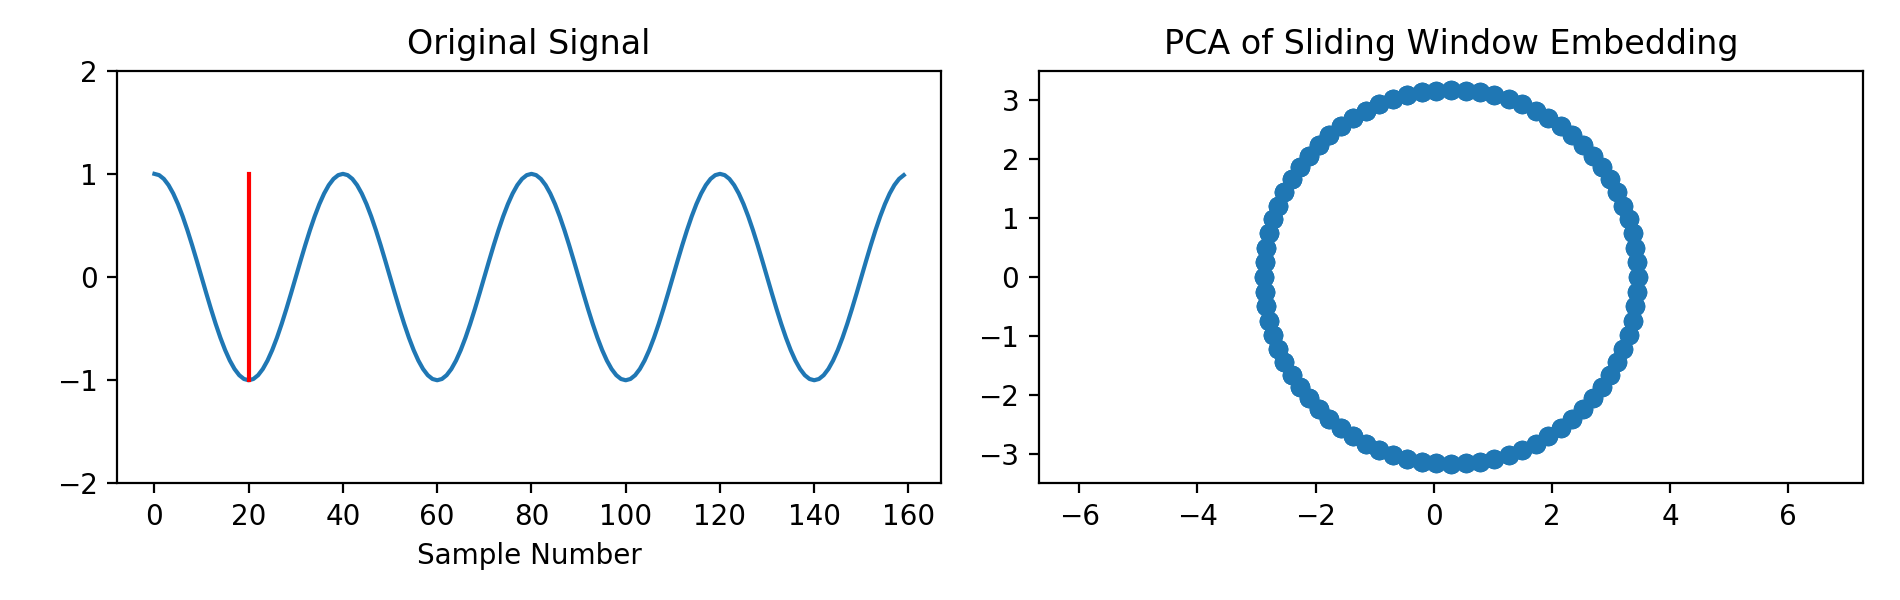

In [4]:
def on_value_change(change):
    execute_computation1()
    
dimslider = widgets.IntSlider(min=1,max=40,value=20,description='Dimension:',continuous_update=False)
dimslider.observe(on_value_change, names='value')

Tauslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=1,description=r'\(\tau :\)' ,continuous_update=False)
Tauslider.observe(on_value_change, names='value')

dTslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=0.5,description='dT: ',continuous_update=False)
dTslider.observe(on_value_change, names='value')

display(widgets.HBox(( dimslider,Tauslider,dTslider)))

def execute_computation1():    

    # Step 1: Setup the signal again in case x was lost
    T = 40 # The period in number of samples
    NPeriods = 4 # How many periods to go through
    N = T*NPeriods # The total number of samples
    t = np.linspace(0, 2*np.pi*NPeriods, N+1)[0:N] # Sampling indices in time
    x = np.cos(t)  # The final signal
    
    clear_output()
    
    # Get slider values
    dim = dimslider.value
    Tau = Tauslider.value
    dT = dTslider.value
    
    #Step 2: Do a sliding window embedding
    X = getSlidingWindow(x, dim, Tau, dT)
    extent = Tau*dim

    #Step 3: Perform PCA down to 2D for visualization
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(X)
    eigs = pca.explained_variance_
    print("lambda1 = %g, lambda2 = %g"%(eigs[0], eigs[1]))

    #Step 4: Plot original signal and PCA of the embedding
    plt.figure(figsize=(9.5, 3))
    ax = plt.subplot(121)
    ax.plot(x)
    ax.set_ylim((-2*max(x), 2*max(x)))
    ax.set_title("Original Signal")
    ax.set_xlabel("Sample Number")
    ax.plot([extent, extent], [np.min(x), np.max(x)], 'r')        
    ax2 = plt.subplot(122)
    ax2.set_title("PCA of Sliding Window Embedding")
    ax2.scatter(Y[:, 0], Y[:, 1])
    ax2.set_aspect('equal', 'datalim')
    plt.tight_layout()
    
execute_computation1()

### Questions
1. For fixed $\tau$:
  1. What does varying the dimension do to the *extent* (the length of the window)?
  1. what dimensions give eigenvalues nearest each other? (Note: dimensions! Plural!) Explain why this is the case. Explain how you might use this information to deduce the period of a signal.
<br><br>
1. What does varying $dT$ do to the PCA embedding? Explain this in terms of the definition of sliding windows above.
<br><br>
1. The command 
```python
np.random.randn(pts)
```
generates an array of length *pts* filled with random values drawn from a standard normal distribution ($\mu=0$, $\sigma=1$). Modify the code above to add random noise to signal. 
  1. Can you still detect the period visually by inspecting the plot of the signal?
  1. Does your method of detecting the period from the first question still work?
  1. How does adding noise change the geometry of the PCA embedding? 
  1. Modify the amplitude of the noise (for example, by multiplying the noise-generating command by a constant) and examine the 2D projection. What feature of the 2D projection appears to imply that the signal is periodic? At what noise amplitude does this feature appear to vanish?




## Non-Periodic Signal Sliding Window
For a contrasting example, we will now examine the sliding window embedding of a non-periodic signal which is a linear function plus Gaussian noise.  The code below sets up the signal and then does the sliding window embedding, as before.  

** Exercise: ** Execute the code. Using the sliders, play around with the parameters of the sliding window embedding and examine the results.  Then answer the questions below.

lambda1 = 1.46697, lambda2 = 0.00315716


<IPython.core.display.Javascript object>


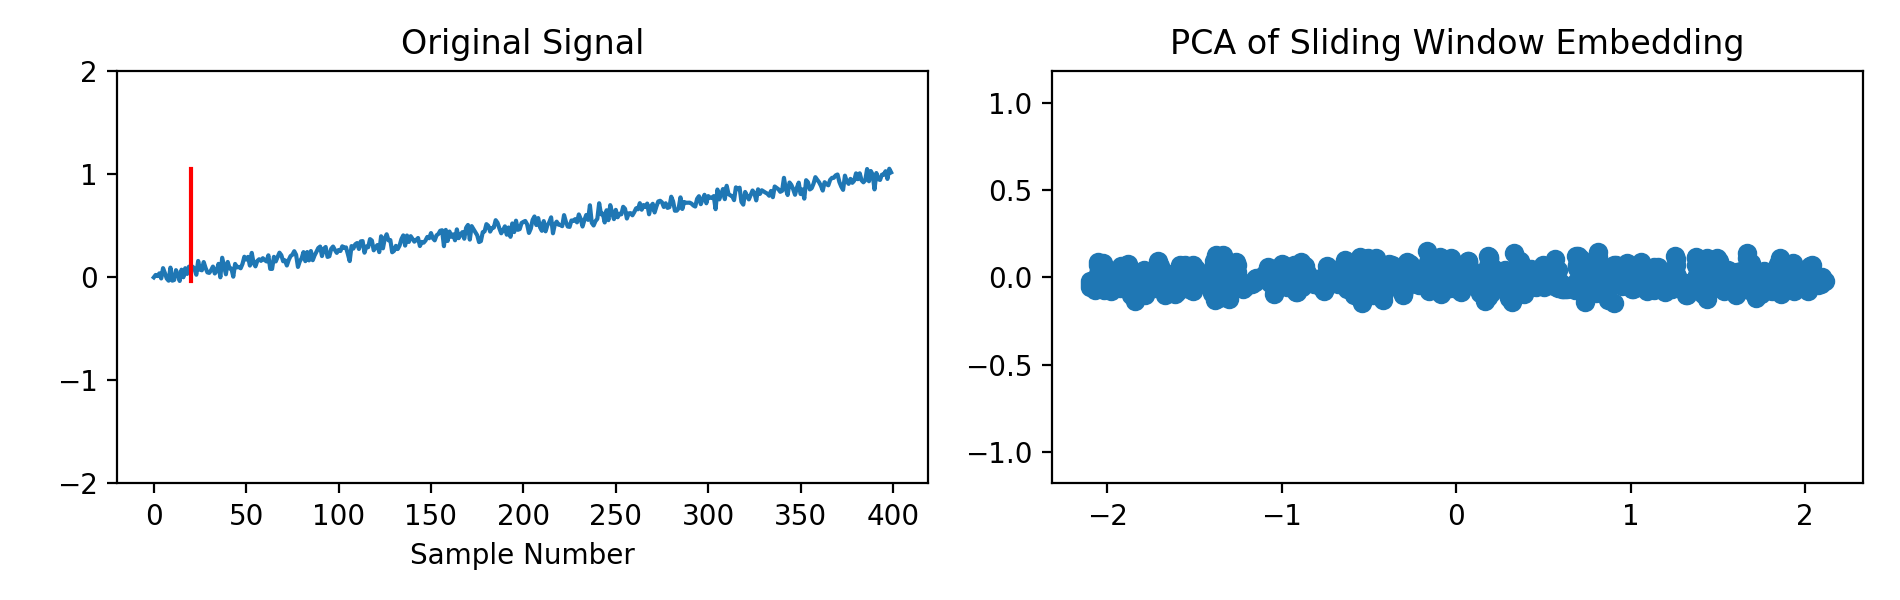

In [5]:
noise = 0.05*np.random.randn(400)

def on_value_change(change):
    execute_computation2()
    
dimslider = widgets.IntSlider(min=1,max=40,value=20,description='Dimension:',continuous_update=False)
dimslider.observe(on_value_change, names='value')

Tauslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=1,description='Tau: ',continuous_update=False)
Tauslider.observe(on_value_change, names='value')

dTslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=0.5,description='dT: ',continuous_update=False)
dTslider.observe(on_value_change, names='value')

display(widgets.HBox(( dimslider,Tauslider,dTslider)))

def execute_computation2():    

    # Step 1: Set up the signal
    x = np.arange(400)
    x = x/float(len(x))
    x = x + noise # Add some noise

    clear_output()
    
    # Get slider values
    dim = dimslider.value
    Tau = Tauslider.value
    dT = dTslider.value
    
    #Step 2: Do a sliding window embedding
    X = getSlidingWindow(x, dim, Tau, dT)
    extent = Tau*dim

    #Step 3: Perform PCA down to 2D for visualization
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(X)
    eigs = pca.explained_variance_
    print("lambda1 = %g, lambda2 = %g"%(eigs[0], eigs[1]))

    #Step 4: Plot original signal and PCA of the embedding
    plt.figure(figsize=(9.5, 3))
    ax = plt.subplot(121)
    ax.plot(x)
    ax.set_ylim((-2, 2))
    ax.set_title("Original Signal")
    ax.set_xlabel("Sample Number")
    ax.plot([extent, extent], [np.min(x), np.max(x)], 'r')        
    ax2 = plt.subplot(122)
    ax2.set_title("PCA of Sliding Window Embedding")
    ax2.scatter(Y[:, 0], Y[:, 1])
    ax2.set_aspect('equal', 'datalim')
    plt.tight_layout()

execute_computation2()

### Questions

1. Notice how changing the window extent doesn't have the same impact as it did in the periodic example above.  Why might this be?
<br><br>
1. Why is the second eigenvalue always tiny?


## Multiple Sines Sliding Window
We will now go back to periodic signals, but this time we will increase the complexity by adding two sines together.  If the ratio between the two sinusoids is a rational number, then they are called *harmonics* of each other.  For example, $\sin(t)$ and $\sin(3t)$ are harmonics of each other. By contrast, if the ratio of the two frequencies is irrational, then the sinusoids are called *incommensurate*.  For example, $\sin(t)$ and $\sin(\pi t)$ are incommensurate.

The plots below are initialized with 

$$f(t) = \sin(\omega t) + \sin(3\omega t),$$

a sum of two harmonics.  

This time, the eigenvalues of PCA will be plotted (up to the first 10), in addition to the red line showing the extent of the window.  Also, 3D PCA will be displayed instead of 2D PCA, and you can click and drag your mouse to view it from different angles.  Colors will be drawn to indicate the position of the window in time, with cool colors (greens and yellows) indicating earlier windows and hot colors (oranges and reds) indicating later windows (using the "jet" colormap).

** Exercise: ** Execute the code. Then play with the sliders, as well as the embedding dimension (note that for the 3-D projection, you can change the view by dragging around. Do!). Then, try changing the second sinusoid to be another multiple of the first. Try both harmonic and incommensurate values. Once you have gotten a feel for the geometries and the eigenvalues, answer the questions below.

<IPython.core.display.Javascript object>


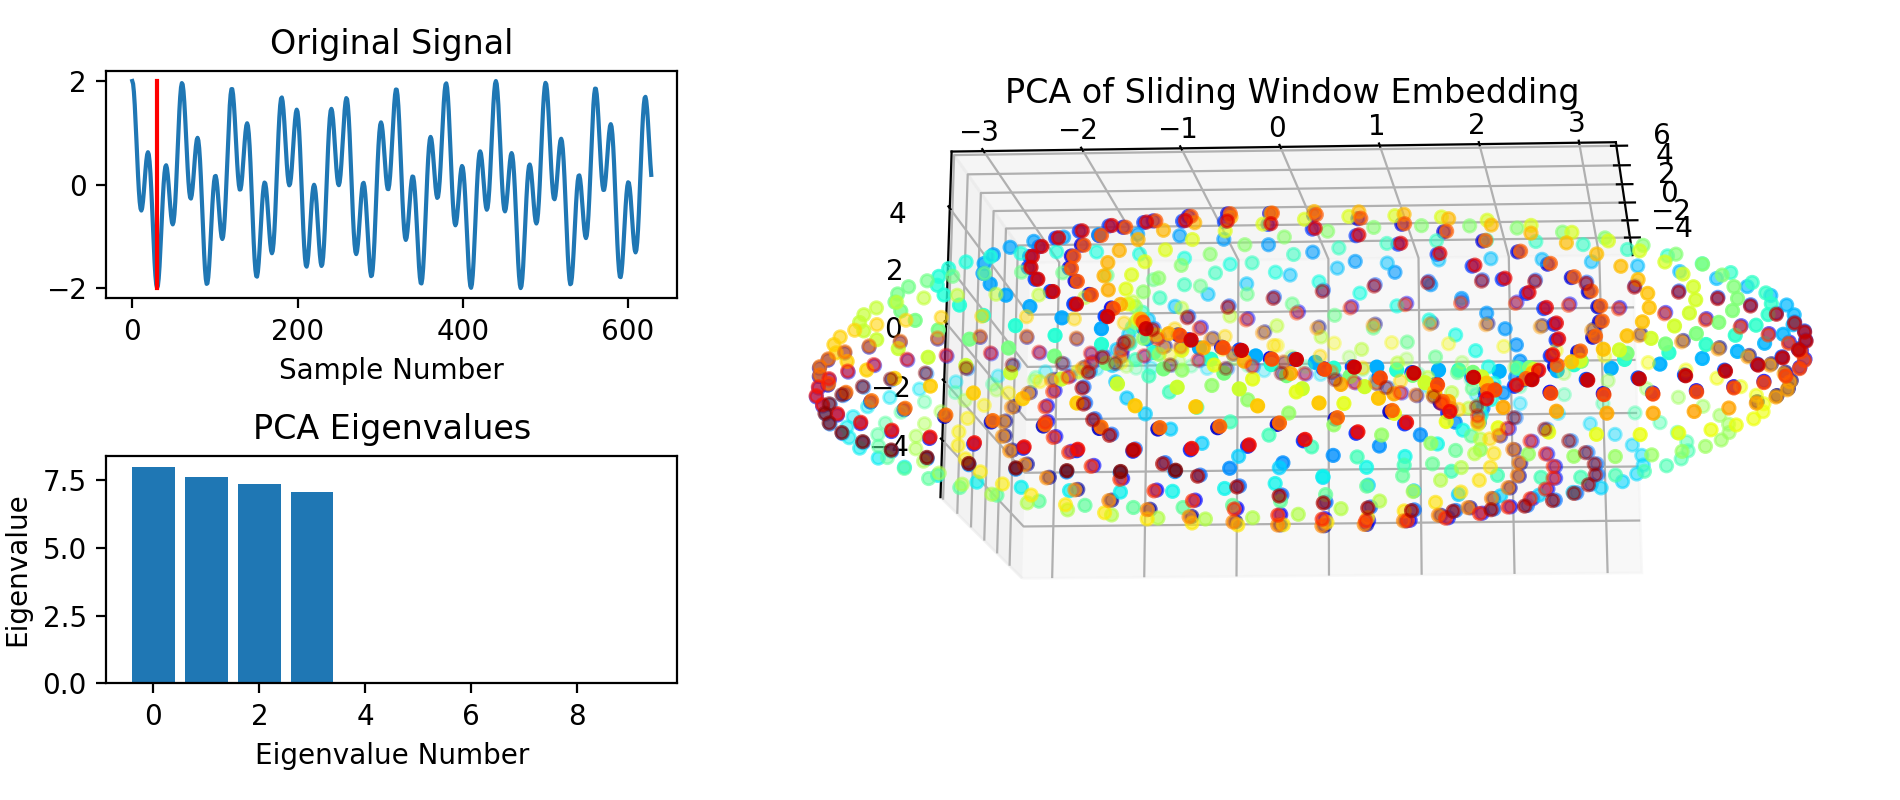

In [8]:
def on_value_change(change):
    execute_computation3()

embeddingdimbox = widgets.Dropdown(options=[2, 3],value=3,description='Embedding Dimension:',disabled=False)
embeddingdimbox.observe(on_value_change,names='value')

secondfreq = widgets.Dropdown(options=[2, 3, np.pi],value=3,description='Second Frequency:',disabled=False)
secondfreq.observe(on_value_change,names='value')

noiseampslider = widgets.FloatSlider(min=0,max=6,step=0.5,value=0,description='Noise Amplitude',continuous_update=False)
noiseampslider.observe(on_value_change, names='value')

dimslider = widgets.IntSlider(min=1,max=100,value=30,description='Dimension:',continuous_update=False)
dimslider.observe(on_value_change, names='value')

Tauslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=1,description='Tau: ',continuous_update=False)
Tauslider.observe(on_value_change, names='value')

dTslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=0.5,description='dT: ',continuous_update=False)
dTslider.observe(on_value_change, names='value')

display(widgets.HBox(( secondfreq,embeddingdimbox,noiseampslider)))
display(widgets.HBox((dimslider,Tauslider,dTslider)))

noise = np.random.randn(10000)

def execute_computation3():
    clear_output()
    
    # Step 1: Setup the signal
    T1 = 20 # The period of the first sine in number of samples
    T2 = T1*secondfreq.value # The period of the second sine in number of samples
    NPeriods = 10 # How many periods to go through, relative to the second sinusoid
    N = T2*NPeriods # The total number of samples
    t = np.arange(N) # Time indices
    x = np.cos(2*np.pi*(1.0/T1)*t) # The first sinusoid
    x += np.cos(2*np.pi*(1.0/T2)*t) # Add the second sinusoid
    x += noiseampslider.value*noise[:len(x)]
    
    # Get widget values
    dim = dimslider.value
    Tau = Tauslider.value
    dT = dTslider.value
    embeddingdim = embeddingdimbox.value
    
    # Step 2: Do a sliding window embedding
    X = getSlidingWindow(x, dim, Tau, dT)
    extent = Tau*dim

    # Step 3: Perform PCA down to dimension chosen for visualization
    pca = PCA(n_components = 10)
    Y = pca.fit_transform(X)
    eigs = pca.explained_variance_

    # Step 4: Plot original signal and PCA of the embedding
    fig = plt.figure(figsize=(9.5, 4)) 
    gs = gridspec.GridSpec(2, 2,width_ratios=[1, 2])
    
    # Plot the signal
    ax = plt.subplot(gs[0,0])
    ax.plot(x)
    ax.plot([extent, extent], [np.min(x), np.max(x)], 'r')
    ax.set_title("Original Signal")
    ax.set_xlabel("Sample Number")

    c = plt.get_cmap('jet')
    C = c(np.array(np.round(np.linspace(0, 255, Y.shape[0])), dtype=np.int32))
    C = C[:, 0:3]

    # Plot the PCA embedding
    if embeddingdim == 3:
        ax2 = plt.subplot(gs[:,1],projection='3d')
        ax2.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=C)
        ax2.set_aspect('equal', 'datalim')
    else:
        ax2 = plt.subplot(gs[:,1])
        ax2.scatter(Y[:, 0], Y[:, 1],c=C)

    ax2.set_title("PCA of Sliding Window Embedding")
    ax2.set_aspect('equal', 'datalim')

    # Plot the eigenvalues as bars
    ax3 = plt.subplot(gs[1,0])
    eigs = eigs[0:min(len(eigs), 10)]
    ax3.bar(np.arange(len(eigs)), eigs)
    ax3.set_xlabel("Eigenvalue Number")
    ax3.set_ylabel("Eigenvalue")
    ax3.set_title("PCA Eigenvalues")

    plt.tight_layout()

    plt.show();

execute_computation3()

## Questions

1. Comment on the relationship between the eigenvalues and the extent (width) of the window.
<br><br>
1. When are the eigenvalues near each other? When are they not?
<br><br>
1. Comment on the change in geometry when the second sinusoid is incommensurate to the first. Specifically, comment on the *intrinsic dimension* of the object in the projection. Can you name the shape in the 3-D projection in the incommensurate case?
<br><br>
1. Try adding noise in like you did in the single frequency case. 
  1. Can you distinguish in the projection between the incommensurate case and the noisy, but harmonic one with second frequency 3? Explain.
  1. What can you say about the eigenvalues in the two cases? Explain your answer.

It seems reasonable to ask what the ideal dimension to embed into is. While that question may be answerable, it would be better to bypass the question altogether. Similarly, it seems that beyond detecting the largest period, these tools are limited in detecting the secondary ones. Topological tools that we will see beginning in the next lab will allow us to make some progress toward that goal.

## Power Spectrum

We saw above that for a rather subtle change in frequency changing the second sinusoid from harmonic to noncommensurate, there is a marked change in the geometry.  By contrast, the power spectral density functions are very close between the two, as shown below.  Hence, it appears that geometric tools are more appropriate for telling the difference between these two types of signals

<IPython.core.display.Javascript object>


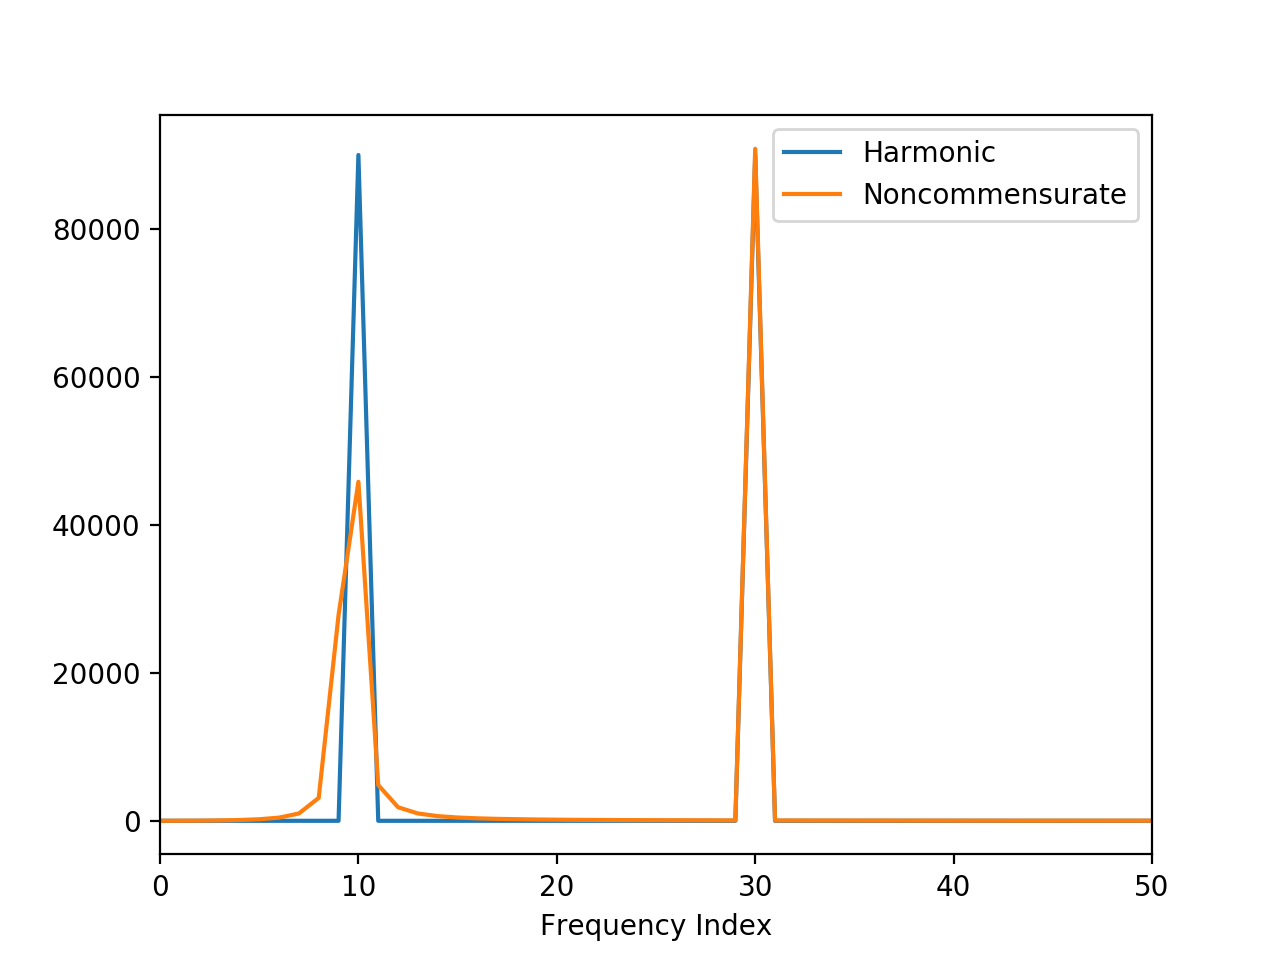

In [7]:
T = 20 #The period of the first sine in number of samples
NPeriods = 10 #How many periods to go through, relative to the faster sinusoid
N = T*NPeriods*3 #The total number of samples
t = np.arange(N) #Time indices

#Make the harmonic signal cos(t) + cos(3t)
xH = np.cos(2*np.pi*(1.0/T)*t) + np.cos(2*np.pi*(1.0/(3*T)*t))
                                        
#Make the incommensurate signal cos(t) + cos(pi*t)
xNC = np.cos(2*np.pi*(1.0/T)*t) + np.cos(2*np.pi*(1.0/(np.pi*T)*t))

plt.figure()
P1 = np.abs(np.fft.fft(xH))**2
P2 = np.abs(np.fft.fft(xNC))**2
plt.plot(np.arange(len(P1)), P1)
plt.plot(np.arange(len(P2)), P2)
plt.xlabel("Frequency Index")
plt.legend({"Harmonic", "Noncommensurate"})
plt.xlim([0, 50])
plt.show();

# Summary

* Signals can be transformed into geometric objects via embeddings.
<br><br>
* Signal properties are captured by the geometry of the sliding window embedding.  Periodicity corresponds to circularity, period length over window size corresponds to roundness, number of incommensurate frequencies corresponds to intrinsic dimension.
<br><br>
* The window extent is one of the most important parameters for determining roundness.
<br><br>
* Adding noise makes things a little trickier to see what's going on by inspection of projections.